In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit , GridSearchCV
from sklearn.metrics import make_scorer , mean_squared_error as MSE , mean_absolute_error as MAE \
, mean_absolute_percentage_error as MAPE

## Data analysis

In [2]:
df_energy = pd.read_csv("data/london_energy.csv")
df_energy.head()

,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [3]:
df_weather = pd.read_csv("data/london_weather.csv")
df_weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


### Average Consumption

In [4]:
df_avg_consumption = df_energy.groupby(['Date'])['KWH'].mean()
df_avg_consumption = pd.DataFrame({"date":df_avg_consumption.index.tolist(),
                                 "Avg Consumption":df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])
print("The analysis will be : ")
print(f"From ---> {df_avg_consumption['date'].min()}")
print(f"To ---> {df_avg_consumption['date'].max()}")
df_avg_consumption.head()

The analysis will be : 
From ---> 2011-11-23 00:00:00
To ---> 2014-02-28 00:00:00


,date,Avg Consumption
0,2011-11-23,6.952692
1,2011-11-24,8.536480
2,2011-11-25,9.499781
3,2011-11-26,10.267707
4,2011-11-27,10.850805


<AxesSubplot:title={'center':'Average consumption of energy'}, xlabel='date'>

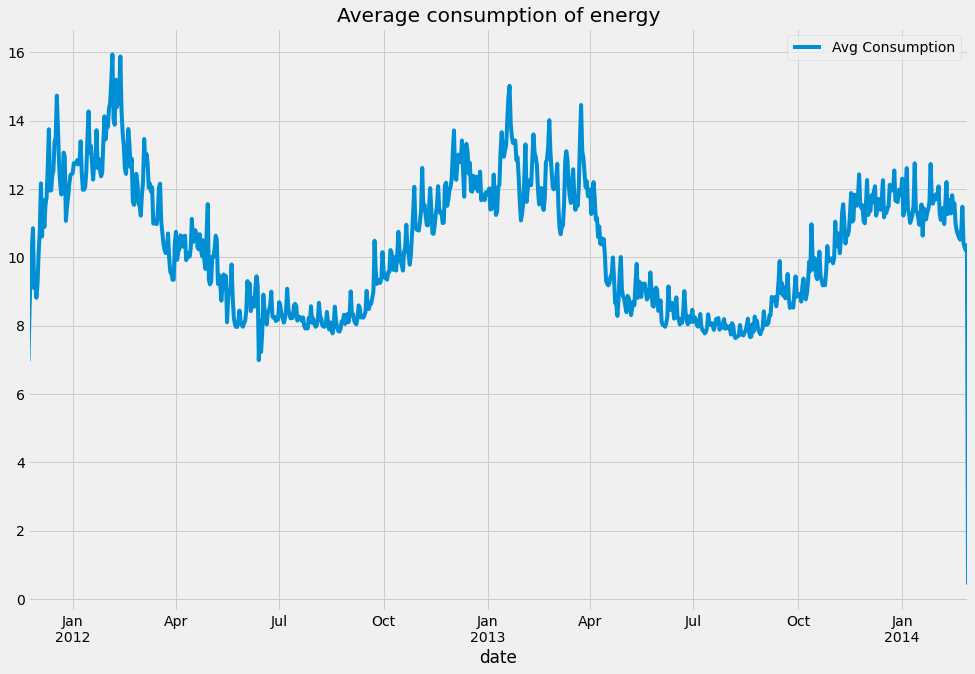

In [5]:
df_avg_consumption.plot(x='date',y='Avg Consumption',
                        figsize=(15,10),
                        style='-',
                       title="Average consumption of energy")

**The seasonal pattern is evident, marked by elevated energy demands in winter and reduced consumption during the summer months. This cyclical behavior recurs annually in the dataset, showcasing varying peak and off-peak values.**

<AxesSubplot:title={'center':'Average consumption of energy in 2012'}, xlabel='date'>

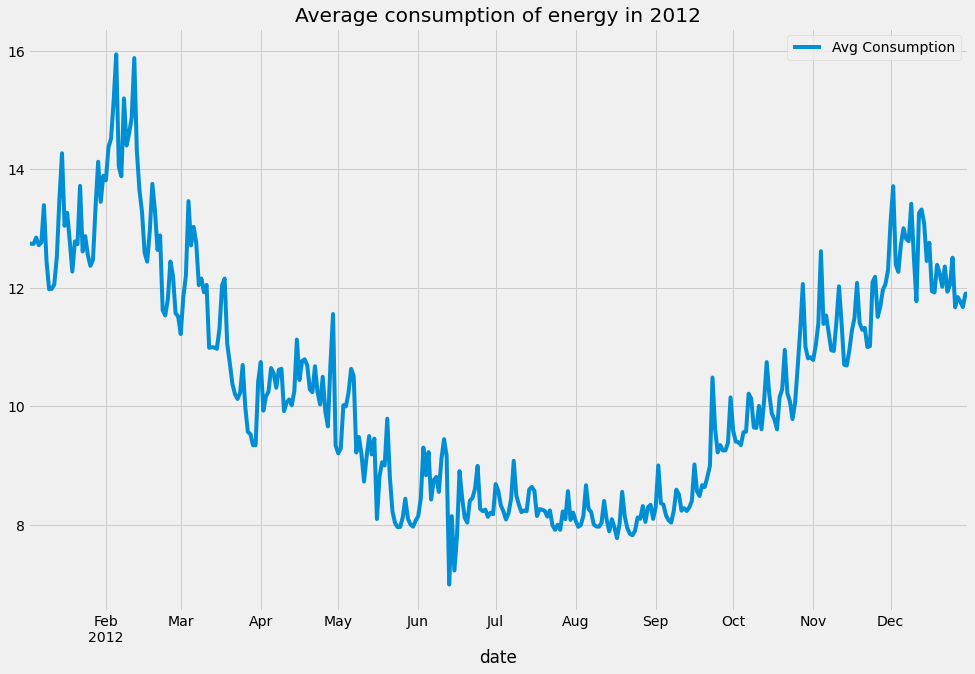

In [6]:
df_avg_consumption.query("date > '2012-01-01' & date < '2013-01-01'")\
                  .plot(x="date", y="Avg Consumption",
                        figsize=(15,10),title="Average consumption of energy in 2012")

### Features extraction

In [7]:
# df_avg_consumption.set_index('Date',inplace=True)
df_avg_consumption['Year'] = df_avg_consumption['date'].dt.year
df_avg_consumption['Month'] = df_avg_consumption['date'].dt.month
df_avg_consumption['Day'] = df_avg_consumption['date'].dt.day
df_avg_consumption['Quarter'] = df_avg_consumption['date'].dt.quarter
df_avg_consumption['Day of Year'] = df_avg_consumption['date'].dt.dayofyear
df_avg_consumption.head()

,date,Avg Consumption,Year,Month,Day,Quarter,Day of Year
0,2011-11-23,6.952692,2011,11,23,4,327
1,2011-11-24,8.536480,2011,11,24,4,328
2,2011-11-25,9.499781,2011,11,25,4,329
3,2011-11-26,10.267707,2011,11,26,4,330
4,2011-11-27,10.850805,2011,11,27,4,331


## Train/Test Split

In [8]:
DATE_TEST_SPLIT = '2013-07-01'

train_mask = df_avg_consumption['date'] < DATE_TEST_SPLIT
train = df_avg_consumption.loc[train_mask]

test_mask = df_avg_consumption['date'] >= DATE_TEST_SPLIT
test = df_avg_consumption.loc[test_mask]

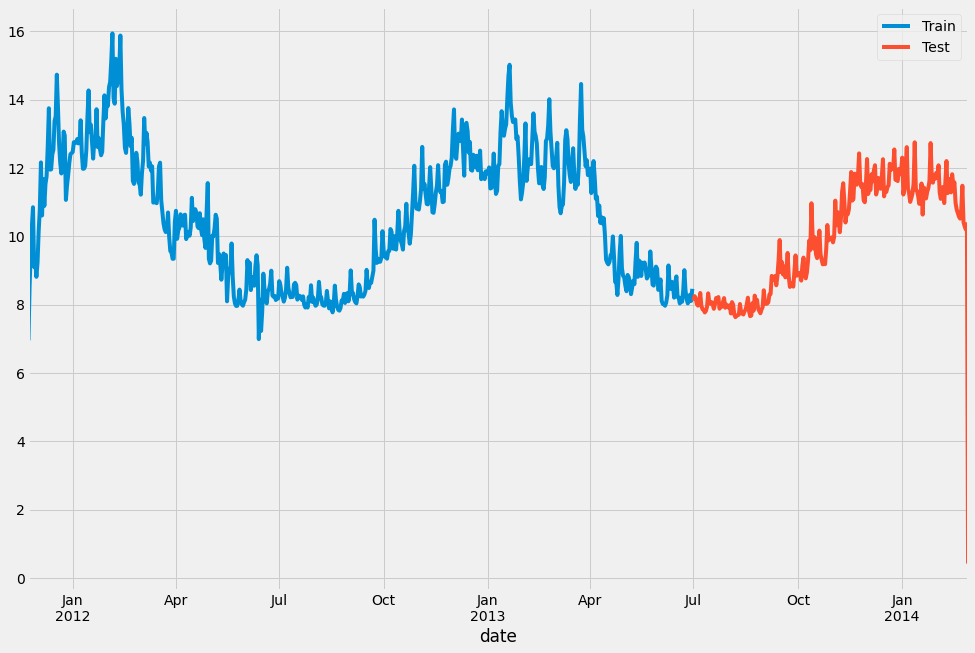

In [9]:
fig , ax = plt.subplots(figsize=(15,10))
train.plot(ax=ax,x='date',y='Avg Consumption',label='Train')
test.plot(ax=ax,x='date',y='Avg Consumption',label='Test')
plt.show()

In [10]:
# save dates
train_dates = train['date'] 
test_dates = test['date']

# drop dates from data
train_data = train.drop(columns=['date'])
test_data = test.drop(columns=['date'])

# features and target column
features = train_data.columns[1:]
target = train_data.columns[0]

In [11]:
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

## Training of XGBoost

In [12]:
cv_split = TimeSeriesSplit(n_splits=3,test_size=100)
reg_model = XGBRegressor()
parameters = {
    "max_depth": [3, 6, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "n_estimators": [100, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}
scoring = {
    'MSE': make_scorer(MSE),
    'MAE': make_scorer(MAE),
    'MAPE': make_scorer(MAPE)
}

grid = GridSearchCV(estimator=reg_model,cv=cv_split,param_grid=parameters,scoring=scoring,refit='MAE')
grid.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 6, 5, 10],
                         'n_estimators': [100, 500, 700, 900, 1000]},
             refit='MAE',
             scoring={'MAE': make_scorer(mean_absolute_error),
                      'MAPE': make_scorer(mean_absolute_percentage_error),
                      'MSE': make_scorer(mean_squared_error)})

In [13]:
best_reg_model = grid.best_estimator_

In [14]:
grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 900}

### Inference

In [15]:
def plot_predictions(test_dates,predictions,y_test):
    pred_df = pd.DataFrame({"date":test_dates , "Prediction":predictions , "Truth":y_test})
    fig , ax = plt.subplots(figsize=(15,5))
    pred_df.plot(ax=ax , x="date",y="Truth")
    pred_df.plot(ax=ax , x="date",y="Prediction")
    ax.legend(['Truth','Prediction'])
    plt.show()
    
def evaluate(predictions,y_test):
    mse = np.round(MSE(predictions,y_test),3)
    mae = np.round(MAE(predictions,y_test),3)
    mape = np.round(MAPE(predictions,y_test),3)
    print(f"Mean Square Error : {MSE(predictions,y_test):.3f}")
    print(f"Mean Absolute Error : {MAE(predictions,y_test):.3f}")    
    print(f"Mean Absolute Percetenge Error : {MAPE(predictions,y_test):.3f}")    
    
    return mse,mae,mape

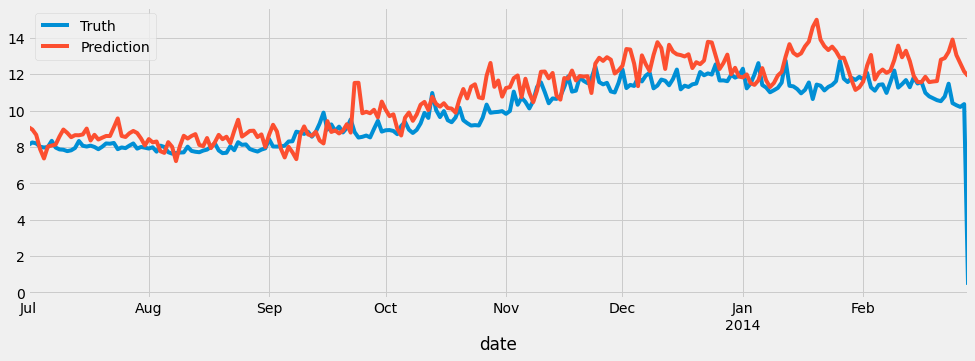

Mean Square Error : 1.943
Mean Absolute Error : 0.974
Mean Absolute Percetenge Error : 0.086


In [16]:
predictions = best_reg_model.predict(X_test)
plot_predictions(test_dates,predictions,y_test)
mse_xgb , mae_xgb , mape_xgb = evaluate(predictions,y_test)

Un MAPE de 0.086 signifie que, en moyenne, les prédictions diffèrent d'environ 8.6% par rapport aux valeurs réelles en termes relatifs.

## Try to achieve better results

We will use auxiliary features that are correlated directly or indirectly to energy consumption. For example, the weather data can play a decisive role when it comes to predicting energy demands. That’s why we choose to enhance our dataset with weather data.

In [17]:
df_weather = pd.read_csv("data/london_weather.csv")
print(df_weather.isna().sum())
print("\n",df_weather.shape)
df_weather.head()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

 (15341, 10)


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [18]:
# parsing dates
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y%m%d")
df_weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [19]:
print(df_weather.isna().sum().sum())
df_weather = df_weather.interpolate(method="ffill")
print(df_weather.isna().sum().sum())

1533
0


In [20]:
# df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather_energy = df_avg_consumption.merge(df_weather, how="inner", on="date")
print(df_weather_energy.shape)
df_weather_energy.head()

(829, 16)


,date,Avg Consumption,Year,Month,Day,Quarter,Day of Year,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-11-23,6.952692,2011,11,23,4,327,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0
1,2011-11-24,8.536480,2011,11,24,4,328,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0
2,2011-11-25,9.499781,2011,11,25,4,329,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0
3,2011-11-26,10.267707,2011,11,26,4,330,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0
4,2011-11-27,10.850805,2011,11,27,4,331,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0


In [21]:
DATE_TEST_SPLIT = '2013-07-01'

train_mask = df_weather_energy['date'] < DATE_TEST_SPLIT
train = df_weather_energy.loc[train_mask]

test_mask = df_weather_energy['date'] >= DATE_TEST_SPLIT
test = df_weather_energy.loc[test_mask]

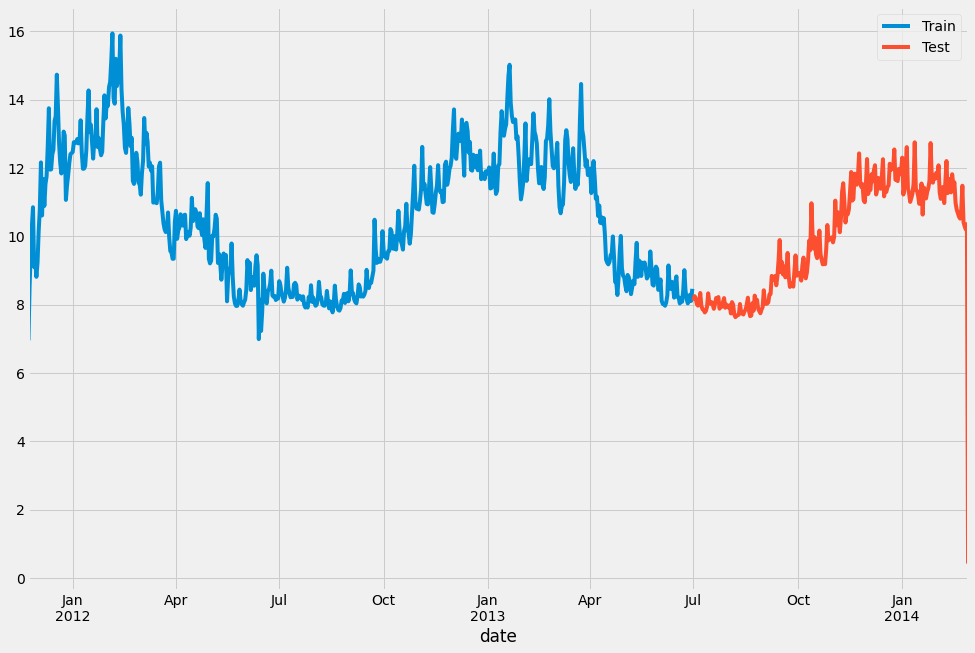

In [22]:
fig , ax = plt.subplots(figsize=(15,10))
train.plot(ax=ax,x='date',y='Avg Consumption',label='Train')
test.plot(ax=ax,x='date',y='Avg Consumption',label='Test')
plt.show()

In [23]:
# save dates
train_dates = train['date'] 
test_dates = test['date']

# drop dates from data
train_data = train.drop(columns=['date'])
test_data = test.drop(columns=['date'])

# features and target column
features = train_data.columns[1:]
target = train_data.columns[0]
print(target)
print(features)

Avg Consumption
Index(['Year', 'Month', 'Day', 'Quarter', 'Day of Year', 'cloud_cover',
       'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp',
       'precipitation', 'pressure', 'snow_depth'],
      dtype='object')


In [24]:
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [25]:
cv_split = TimeSeriesSplit(n_splits=3,test_size=100)
reg_model = XGBRegressor()
parameters = {
    "max_depth": [3, 6, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "n_estimators": [100, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}
scoring = {
    'MSE': make_scorer(MSE),
    'MAE': make_scorer(MAE),
    'MAPE': make_scorer(MAPE)
}

grid = GridSearchCV(estimator=reg_model,cv=cv_split,param_grid=parameters,scoring=scoring,refit='MAE')
grid.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 6, 5, 10],
                         'n_estimators': [100, 500, 700, 900, 1000]},
             refit='MAE',
             scoring={'MAE': make_scorer(mean_absolute_error),
                      'MAPE': make_scorer(mean_absolute_percentage_error),
                      'MSE': make_scorer(mean_squared_error)})

In [26]:
best_reg_model = grid.best_estimator_
print(grid.best_params_)

{'colsample_bytree': 0.3, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}


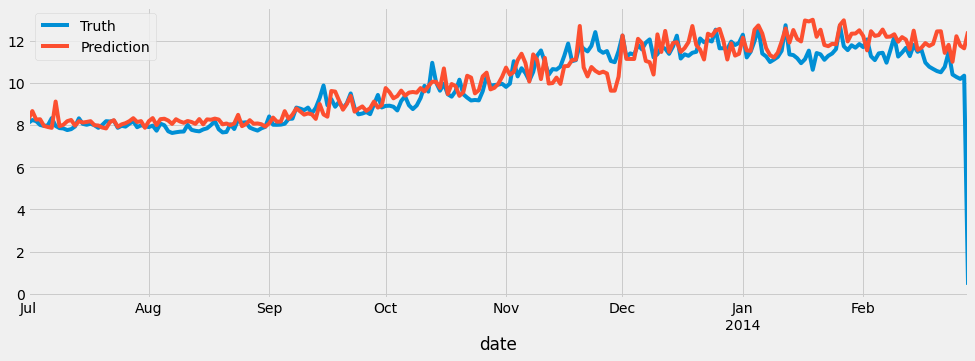

Mean Square Error : 1.027
Mean Absolute Error : 0.542
Mean Absolute Percetenge Error : 0.051


In [27]:
predictions = best_reg_model.predict(X_test)
plot_predictions(test_dates,predictions,y_test)
mse_xgb_wea , mae_xgb_wea , mape_xgb_wea = evaluate(predictions,y_test)

### Comparison

In [28]:
metrics_xgboost = [mse_xgb,mae_xgb,mape_xgb]
metrics_xgboost_weather_data = [mse_xgb_wea,mae_xgb_wea,mape_xgb_wea]

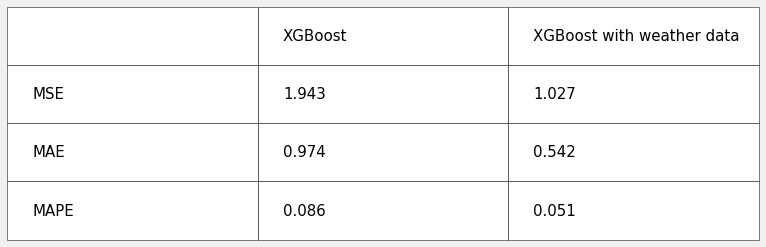

In [55]:
data = [
    ["", "XGBoost", "XGBoost with weather data"],
    ["MSE", metrics_xgboost[0], metrics_xgboost_weather_data[0]],
    ["MAE", metrics_xgboost[1], metrics_xgboost_weather_data[1]],
    ["MAPE", metrics_xgboost[2], metrics_xgboost_weather_data[2]],
]
df = pd.DataFrame(data[1:], columns=data[0])

fig, ax = plt.subplots(figsize=(12,4))
ax.axis('off')
table = ax.table(cellText=data, loc='center', cellLoc="left", colLabels=None,bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(1., 1.)
plt.show()

The weather data improve the performance in the model by a significant margin. In the XGBoost scenario the MSE is reduced by almost 52% ,the MAE is reduced by almost 55% ,   while the MAPE moved from 8.6% to 5.1%